In [1]:
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns

from lifelines import KaplanMeierFitter as KM
from lifelines import CoxPHFitter as cox
from matplotlib import pyplot as plt
from pandas import DataFrame as df
from scipy import stats
from IPython.display import Image

import matplotlib
import matplotlib.font_manager as fm
from matplotlib.ft2font import FT2Font
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def get_font(*args, **kwargs):
    return FT2Font(*args, **kwargs)

fm.get_font = get_font

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
import gc
gc.collect()

20

# Global Paths

In [10]:
data_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/data/'
gsea_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/GSEA/'
result_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/results/'
panel_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/panels/Figure1/'
table_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/Tables/TableS1/'

In [4]:
gene_sets = {}
with open(gsea_home + '/gene_sets/NREC_REC_91061.gmt', 'r') as f:
    for lines in f:
        lines = lines.rstrip().split('\t')
        gene_sets[lines[0]] = lines[2:]

# Figure Plan

    A: graph illustration of the entire story​

    B-C: ability of pre-treatment expr, post-treatment expr and TIEC in determining patient response of anti-PD1 (melanoma)​

    D: volcano or better, identification of non-responder TIEC and responder TIEC (NREC and REC)​

    E-F: functional annotation of NREC and REC genes​

    ​

    Scale-up: from melanoma to other cancer types​

    Plan A: association between NREC and REC genes in TCGA treatment-naïve samples, from melanoma to other cancer types​

    Association with immune cell infiltrations, some case studies​

    Association with prognosis (cross-term with immune response), some case studies​

    Plan B (ongoing): ​

    Find other pre-/post-treatment RNA-seq data in different cancer types, get NREC and REC signatures, generate consensus NREC/REC

## A. Schematic

## B-C.PCAs, density plots and AUC

In [4]:
# See folders 'panels/Figure1/PCA' and notebook 'Shift_theory_establishement.ipynb'

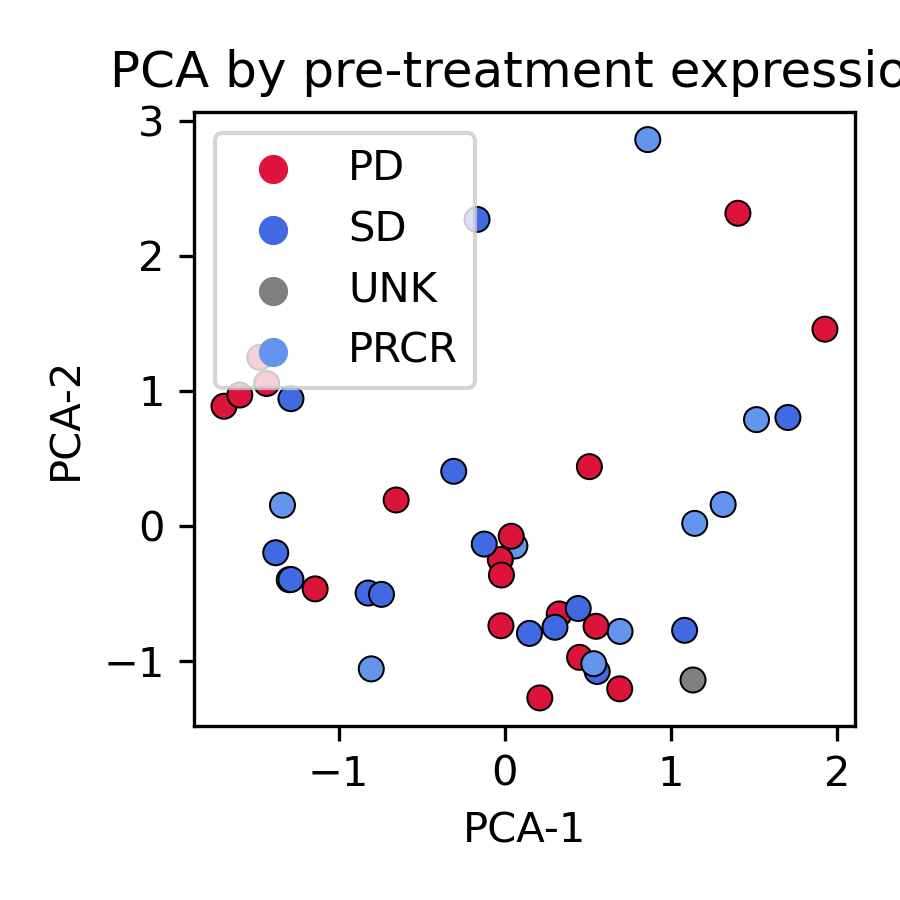

In [20]:
# PCAs
Image(filename=panel_home + '/PCA/pre_PCA_scatter.png', retina=True)

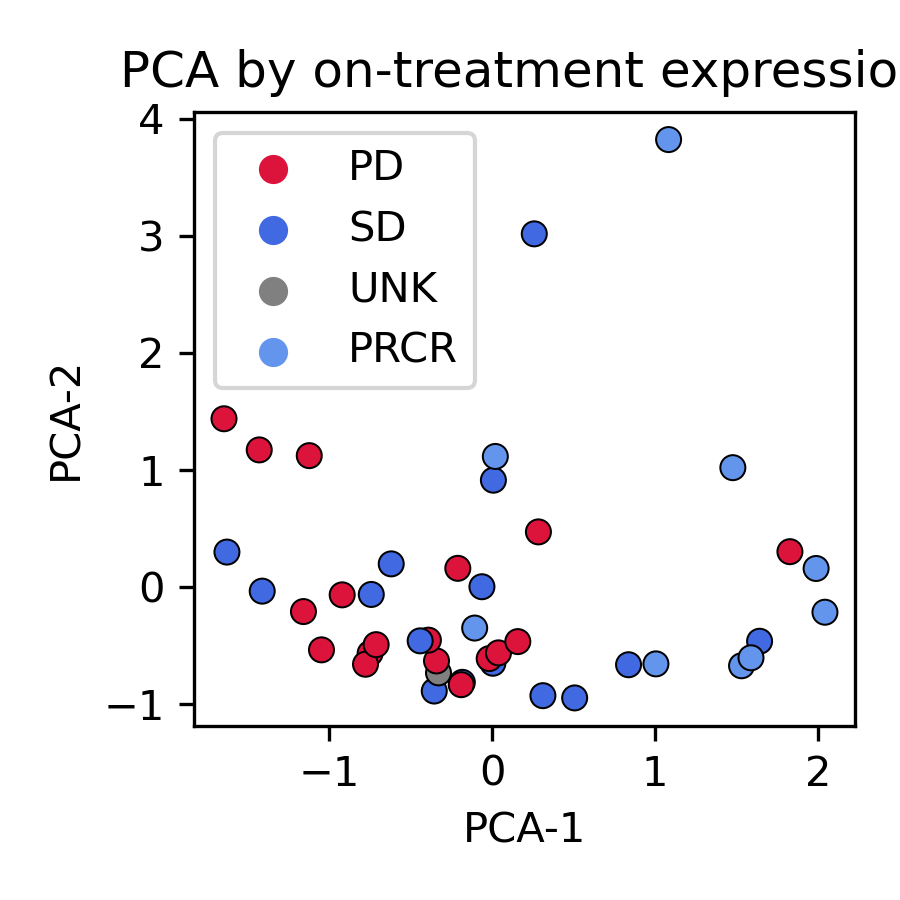

In [21]:
Image(filename=panel_home + '/PCA/on_PCA_scatter.png', retina=True)

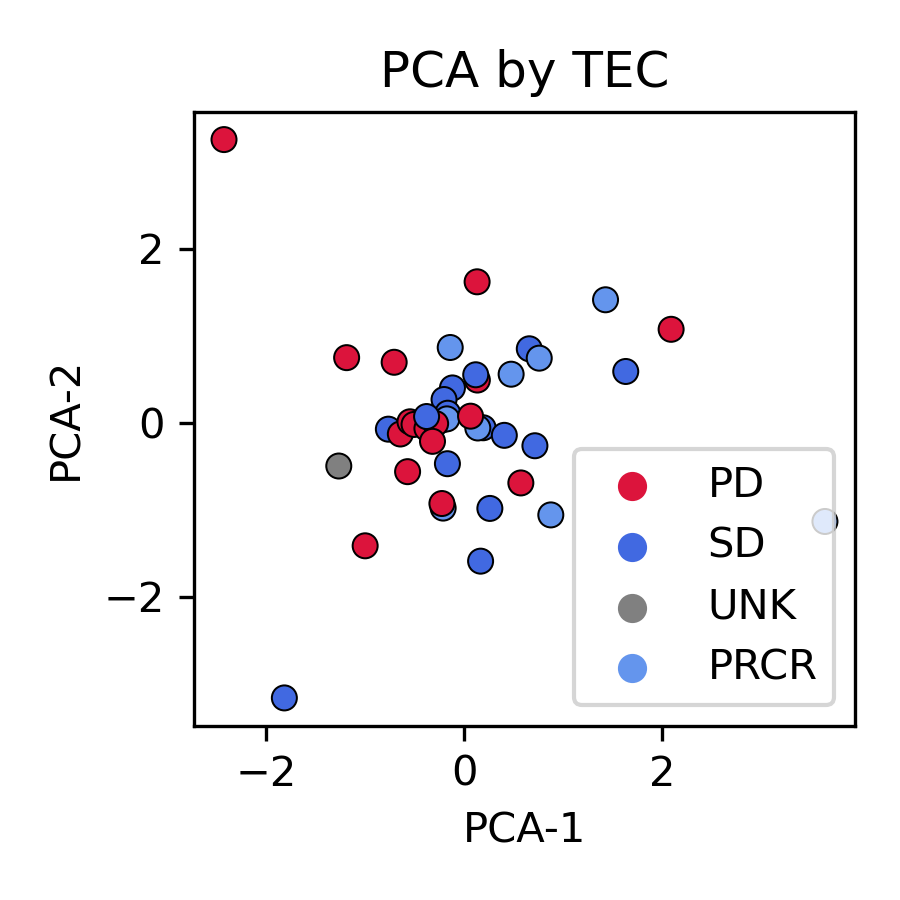

In [22]:
Image(filename=panel_home + '/PCA/fc_PCA_scatter.png', retina=True)

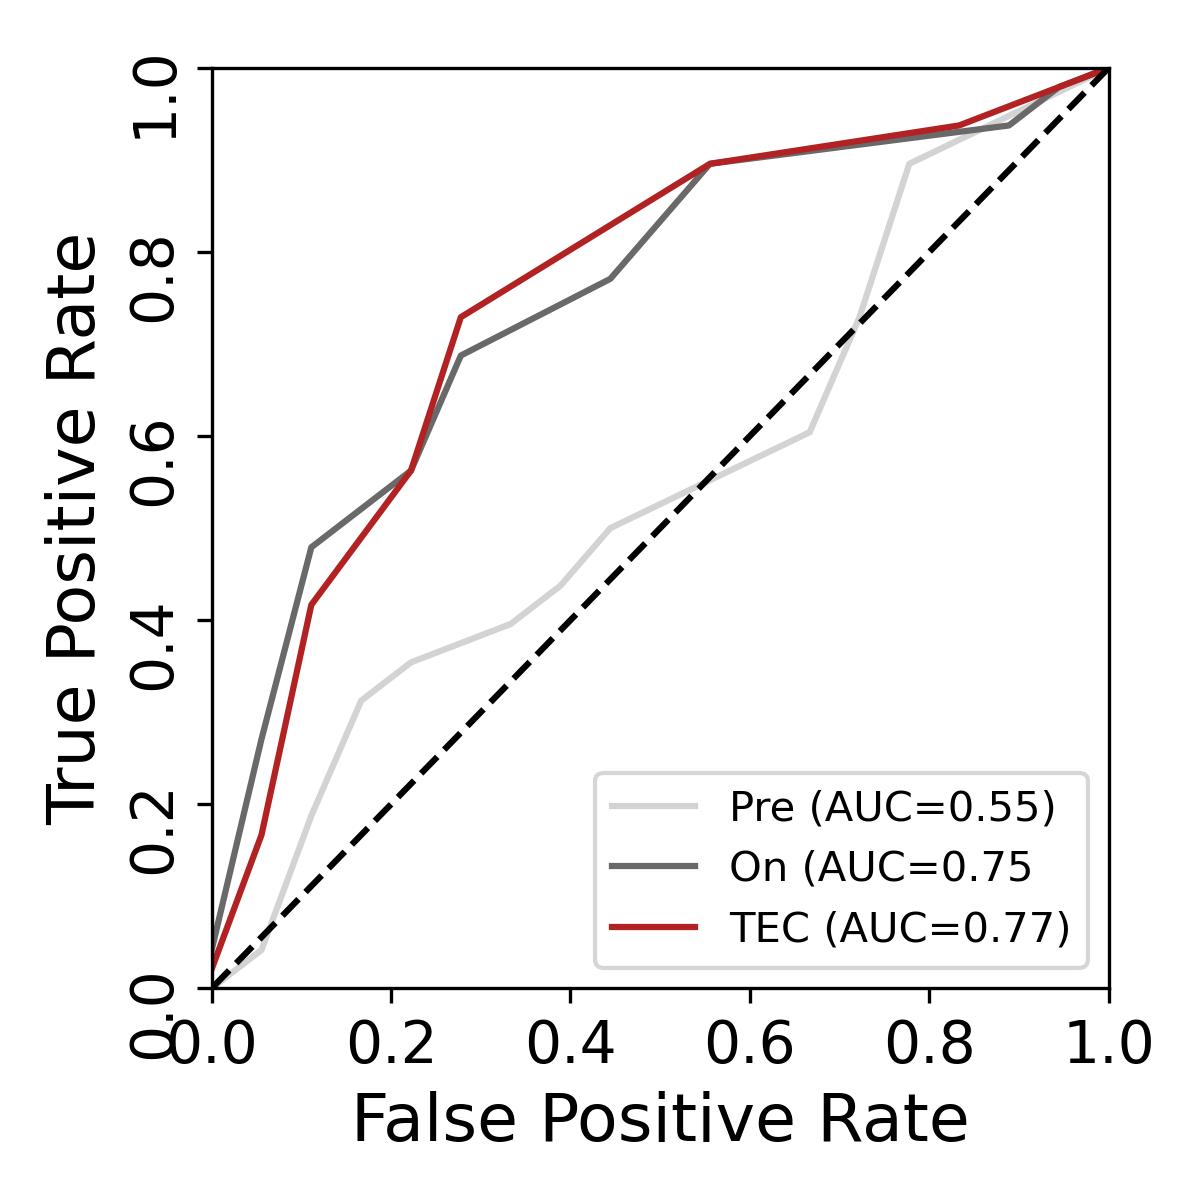

In [26]:
# AUC
Image(filename=panel_home + '/PCA/AUC_PCA1.png', retina=True)

## D. Volcano with annotation

In [5]:
tec_deg = pd.read_csv(panel_home + '/volcano/TEC_91061_DEG_all.csv',
                      header=0, index_col=0, sep=',')
tec_deg

,log2FC(P-N),ranksum_stat,ranksum_p,log10P
A2M,-0.108075,-0.787909,0.430750,0.365775
AAAS,0.261550,2.084147,0.037147,1.430079
AACS,0.380061,2.922889,0.003468,2.459921
AAGAB,0.197753,1.829983,0.067253,1.172292
AAMDC,0.042494,0.609994,0.541866,0.266108
...,...,...,...,...
ZSCAN9,0.276723,1.042074,0.297378,0.526692
ZWILCH,0.454592,2.770391,0.005599,2.251897
ZWINT,0.348637,1.575819,0.115068,0.939047
ZYX,-0.131680,-0.711660,0.476675,0.321777


In [8]:
tec_deg['Signature'] = 'N/A'
tec_deg.at[gene_sets['NREC_profile'], 'Signature'] = 'R signature'
tec_deg.at[gene_sets['REC_profile'], 'Signature'] = 'S signature'
tec_deg = tec_deg.sort_values(by='ranksum_stat', ascending=False)

In [11]:
tec_deg.to_csv(table_home + 'RS_signature_gene_list.csv', sep=',')

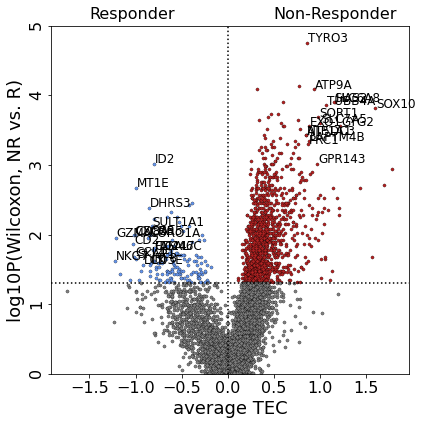

In [84]:
# volcano:
plt.figure(figsize=(6, 6))
tmp_sig_deg = tec_deg[tec_deg['ranksum_p'] <= 0.05]
sns.scatterplot(x='log2FC(P-N)', y='log10P', s=10, edgecolor='k',
                data=tmp_sig_deg[tmp_sig_deg['log2FC(P-N)'] > 0], color='firebrick')
sns.scatterplot(x='log2FC(P-N)', y='log10P', s=10, edgecolor='k',
                data=tmp_sig_deg[tmp_sig_deg['log2FC(P-N)'] < 0], color='cornflowerblue')
sns.scatterplot(x='log2FC(P-N)', y='log10P', s=10, edgecolor='k',
                data=tec_deg[tec_deg['ranksum_p'] > 0.05], color='grey')

# annotation
tmp_top_nrec = tec_deg[tec_deg['log10P'] >= 3]
tmp_top_nrec = tmp_top_nrec[tmp_top_nrec['log2FC(P-N)'] >= 0.8]

tmp_top_rec = tec_deg[tec_deg['log10P'] >= 1.5]
tmp_top_rec = tmp_top_rec[tmp_top_rec['log2FC(P-N)'] <= -0.8]


for g in tmp_top_nrec.index:
    plt.text(x=tec_deg.loc[g, 'log2FC(P-N)'] + 0.01, y=tec_deg.loc[g, 'log10P'] + 0.01, s=g, fontsize=12)

for g in tmp_top_rec.index:
    plt.text(x=tec_deg.loc[g, 'log2FC(P-N)'] + 0.01, y=tec_deg.loc[g, 'log10P'] + 0.01, s=g, fontsize=12)

plt.text(x=0.5, y=5.1, s='Non-Responder', fontsize=16)
plt.text(x=-1.5, y=5.1, s='Responder', fontsize=16)
# finishing
plt.axvline(x=0., ls=':', c='k')
plt.axhline(y=-np.log10(0.05), ls=':', c='k')

plt.xlabel('average TEC', fontsize=18)
plt.ylabel('log10P(Wilcoxon, NR vs. R)', fontsize=18)
plt.yticks(rotation=90, fontsize=16)
plt.xticks(rotation=0, fontsize=16)
plt.ylim(0, 5)

plt.tight_layout()
fig = plt.gcf()
fig.savefig(panel_home + 'volcano/volcano_tec_sig.pdf', transparent=True)
fig.savefig(panel_home + 'volcano/volcano_tec_sig.png', dpi=300, transparent=True)
plt.show()

## E-F. Pathway enrichment

In [90]:
enrich_nrec = pd.read_csv(gsea_home + 'NREC_REC_enrichment/sig_defc_91061_up_0.05/MSigDB_Hallmark_2020.Human.enrichr.reports.txt',
                          header=0, index_col=1, sep='\t')
enrich_rec = pd.read_csv(gsea_home + 'NREC_REC_enrichment/sig_defc_91061_down_0.05/MSigDB_Hallmark_2020.Human.enrichr.reports.txt',
                          header=0, index_col=1, sep='\t')

In [91]:
enrich_nrec.head()

,Gene_set,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
Term,,,,,,,,,
Myc Targets V1,MSigDB_Hallmark_2020,74/200,1.771959e-39,8.859793e-38,0,0,9.832565,877.347344,YWHAE;SLC25A3;HSP90AB1;MCM7;PWP1;PHB2;RRP9;CDC...
E2F Targets,MSigDB_Hallmark_2020,73/200,1.731679e-38,4.329199e-37,0,0,9.614187,835.945337,TOP2A;MCM7;DSCC1;CSE1L;BUB1B;HMGB3;BRCA1;IPO7;...
G2-M Checkpoint,MSigDB_Hallmark_2020,61/200,2.213764e-27,3.689607e-26,0,0,7.257527,445.431481,TOP2A;CCNT1;CCNF;HMGB3;CDC20;CHAF1A;PTTG1;EXO1...
Myc Targets V2,MSigDB_Hallmark_2020,30/58,6.988301e-22,8.735377e-21,0,0,17.347906,845.062224,NOLC1;TMEM97;PHB;WDR43;RRP9;TBRG4;HSPD1;UNG;TC...
mTORC1 Signaling,MSigDB_Hallmark_2020,51/200,2.787024e-19,2.787024e-18,0,0,5.607833,239.589869,GPI;PITPNB;CCNF;ATP2A2;TMEM97;ENO1;VLDLR;RRP9;...


In [92]:
enrich_rec.head()

,Gene_set,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
Term,,,,,,,,,
Allograft Rejection,MSigDB_Hallmark_2020,20/200,9.587500e-18,3.643250e-16,0,0,18.376284,720.094373,GPR65;GZMA;NCF4;PRF1;CD3E;ITGAL;CD3D;PSMB10;CD...
Interferon Gamma Response,MSigDB_Hallmark_2020,15/200,9.712254e-12,1.845328e-10,0,0,12.865737,326.244626,CIITA;GCH1;C1S;GZMA;NMI;PSMB10;VAMP8;HLA-DMA;C...
Complement,MSigDB_Hallmark_2020,9/200,1.116645e-05,1.060813e-04,0,0,7.129682,81.296889,DPP4;CTSO;GCA;C1S;LCK;SPOCK2;GZMA;FDX1;LCP2
Inflammatory Response,MSigDB_Hallmark_2020,9/200,1.116645e-05,1.060813e-04,0,0,7.129682,81.296889,ABCA1;CD82;GCH1;LCK;IL2RB;LCP2;NMI;CXCR6;TNFRSF1B
Apoptosis,MSigDB_Hallmark_2020,8/161,1.708139e-05,1.298186e-04,0,0,7.866287,86.352336,CD2;CASP8;GCH1;DPYD;PRF1;CFLAR;BID;BIRC3


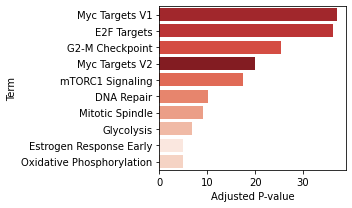

In [118]:
plt.figure(figsize=(5, 3))
pal = sns.color_palette('Reds_r', 10)
rank = enrich_nrec['Odds Ratio'][:10].argsort().argsort()
sns.barplot(y=enrich_nrec.index[:10],
            x=-np.log10(enrich_nrec['Adjusted P-value'][:10]),
            palette=np.array(pal[::-1])[rank])
plt.tight_layout()
fig = plt.gcf()
fig.savefig(panel_home + 'enrichbar/NREC.pdf', transparent=True)
fig.savefig(panel_home + 'enrichbar/NREC.png', dpi=300, transparent=True)
plt.show()

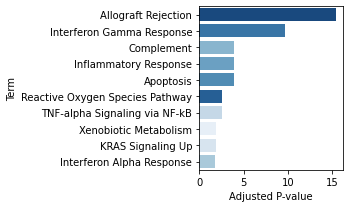

In [117]:
plt.figure(figsize=(5, 3))
pal = sns.color_palette('Blues_r', 10)
rank = enrich_rec['Odds Ratio'][:10].argsort().argsort()
sns.barplot(y=enrich_rec.index[:10],
            x=-np.log10(enrich_rec['Adjusted P-value'][:10]),
            palette=np.array(pal[::-1])[rank])
plt.tight_layout()
fig = plt.gcf()
fig.savefig(panel_home + 'enrichbar/REC.pdf', transparent=True)
fig.savefig(panel_home + 'enrichbar/REC.png', dpi=300, transparent=True)
plt.show()

## G. Survival bubble plot

In [9]:
ave_ec_expr = pd.read_csv(result_home + '/enrichEC_TCGA/z_scored_average_EC_expr_TCGA.csv',
                          header=0, index_col=0, sep=',')

In [10]:
clinical_info = pd.read_csv(data_home + '/survival.TableS2.191002.csv',
                            header=0, index_col=1, encoding='utf-8', sep=',')

In [8]:
def km_plot(data, quantile_frac, measure, metric, ctype, path):
    upper = data[data[measure] > data[measure].quantile(1 - quantile_frac)]
    lower = data[data[measure] <= data[measure].quantile(quantile_frac)]
    print(upper.shape, lower.shape)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    
    kmf_upper = KM().fit(durations=upper[metric + '.time'], event_observed=upper[metric], label='High ' + measure)
    kmf_upper.plot(ax=ax, ci_show=False, show_censors=True, color='crimson')
    
    kmf_lower = KM().fit(durations=lower[metric + '.time'], event_observed=lower[metric], label='Low ' + measure)
    kmf_lower.plot(ax=ax, ci_show=False, show_censors=True, color='royalblue')
    
    plt.title(measure + ' in ' + ctype)
    
    plt.tight_layout()
    fig = plt.gcf()
    fig.savefig(path, transparent=True)
    
    plt.show()
    return

In [10]:
cox_ec_tcga = df(index=ave_ec_expr['cancer_type'].unique(), columns=['PFI_coef_NREC', 'PFI_coef_REC', 'PFI_p_NREC', 'PFI_p_REC',
                                                                     'OS_coef_NREC', 'OS_coef_REC', 'OS_p_NREC', 'OS_p_REC'])
for ct in ave_ec_expr['cancer_type'].unique():
    tmp_ct = ave_ec_expr[ave_ec_expr['cancer_type'] == ct]
    for p in tmp_ct.index:
        if p[:12] in clinical_info.index:
            tmp_ct.at[p, 'PFI'] = clinical_info.loc[p[:12], 'PFI']
            tmp_ct.at[p, 'PFI.time'] = clinical_info.loc[p[:12], 'PFI.time']
            tmp_ct.at[p, 'OS'] = clinical_info.loc[p[:12], 'OS']
            tmp_ct.at[p, 'OS.time'] = clinical_info.loc[p[:12], 'OS.time']
    tmp_ct = tmp_ct.dropna(axis=0, how='any')
    cph_pfi = cox()
    cph_pfi.fit(tmp_ct[['ave_z_NREC', 'ave_z_REC', 'PFI', 'PFI.time']], duration_col='PFI.time', event_col='PFI')
    cox_ec_tcga.at[ct, 'PFI_coef_NREC'] = cph_pfi.summary.loc['ave_z_NREC', 'coef']
    cox_ec_tcga.at[ct, 'PFI_coef_REC'] = cph_pfi.summary.loc['ave_z_REC', 'coef']
    cox_ec_tcga.at[ct, 'PFI_p_NREC'] = cph_pfi.summary.loc['ave_z_NREC', 'p']
    cox_ec_tcga.at[ct, 'PFI_p_REC'] = cph_pfi.summary.loc['ave_z_REC', 'p']

    cph_os = cox()
    cph_os.fit(tmp_ct[['ave_z_NREC', 'ave_z_REC', 'OS', 'OS.time']], duration_col='OS.time', event_col='OS')
    cox_ec_tcga.at[ct, 'OS_coef_NREC'] = cph_os.summary.loc['ave_z_NREC', 'coef']
    cox_ec_tcga.at[ct, 'OS_coef_REC'] = cph_os.summary.loc['ave_z_REC', 'coef']
    cox_ec_tcga.at[ct, 'OS_p_NREC'] = cph_os.summary.loc['ave_z_NREC', 'p']
    cox_ec_tcga.at[ct, 'OS_p_REC'] = cph_os.summary.loc['ave_z_REC', 'p']

/home/dyang-server/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/dyang-server/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/dyang-server/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

/home/dyang-server/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/dyang-server/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/dyang-server/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

/home/dyang-server/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/dyang-server/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/dyang-server/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [11]:
cox_ec_tcga

,PFI_coef_NREC,PFI_coef_REC,PFI_p_NREC,PFI_p_REC,OS_coef_NREC,OS_coef_REC,OS_p_NREC,OS_p_REC
LUSC,-0.403528,-0.136091,0.433052,0.511924,-0.0445727,0.108916,0.91674,0.535864
OV,-0.558711,-0.0789116,0.273411,0.587965,-0.516542,-0.0813707,0.350614,0.606929
PCPG,2.9426,0.166205,0.057625,0.761871,3.58927,-0.979297,0.217915,0.269106
KIRC,2.9678,0.790312,1.23898e-10,8.38896e-05,2.08984,0.533966,4.24344e-06,0.00539288
CESC,0.674338,-0.457524,0.388949,0.11891,0.858902,-0.379591,0.276517,0.183778
BRCA,0.393109,-0.313631,0.322125,0.090761,0.366203,-0.320697,0.343764,0.079716
HNSC,0.834714,-0.25631,0.0877196,0.15581,1.40177,-0.0760991,0.0028619,0.649554
COAD,0.593019,-0.0854221,0.291905,0.705603,0.10176,-0.0714188,0.867542,0.770405
LIHC,0.891188,-0.615723,0.014786,0.00167169,2.07733,-0.277897,1.93799e-06,0.22827
PAAD,2.21294,0.43815,6.40863e-06,0.0535638,1.70143,0.3448,0.00191231,0.142126


In [134]:
cox_ec_tcga

,PFI_coef_NREC,PFI_coef_REC,PFI_p_NREC,PFI_p_REC,OS_coef_NREC,OS_coef_REC,OS_p_NREC,OS_p_REC
LUSC,-0.614805,-0.107897,0.412175,0.510214,0.0932448,0.1171,0.881535,0.408105
OV,-0.539575,-0.0536073,0.429303,0.632649,-0.622523,-0.0618796,0.403114,0.612553
PCPG,4.60007,-0.0664476,0.026264,0.878215,4.44014,-1.00913,0.203043,0.174255
KIRC,5.27643,0.687789,4.59703e-15,0.000262827,3.99663,0.461014,4.36271e-10,0.0100519
CESC,1.78453,-0.281915,0.118742,0.197589,1.29971,-0.316416,0.253424,0.138651
BRCA,0.577726,-0.299709,0.261406,0.0436783,0.310034,-0.323597,0.538333,0.0272806
HNSC,1.15352,-0.266189,0.088101,0.034758,1.986,-0.152335,0.00223947,0.193169
COAD,2.48502,-0.0451241,0.00784929,0.805078,0.727724,-0.0433487,0.455313,0.824613
LIHC,1.01605,-0.577499,0.0061157,6.42778e-05,2.27457,-0.432775,2.72327e-07,0.0110824
PAAD,4.41157,0.208669,1.43249e-06,0.318684,3.51841,0.166423,0.000330654,0.426809


In [135]:
cox_ec_tcga.to_csv(result_home + '/enrichEC_TCGA/average_EC_cox_regression_TCGA.csv')

In [53]:
tmp_cross = df(cox_ec_tcga['OS_coef_NREC'] * cox_ec_tcga['OS_coef_REC'])
tmp_cross_neg = tmp_cross[tmp_cross[0] < 0]
print(tmp_cross_neg)

               0
LUSC -0.00485466
PCPG    -3.51496
CESC   -0.326031
BRCA    -0.11744
HNSC   -0.106673
COAD  -0.0072676
LIHC   -0.577282
KICH   -0.290421
UCEC   -0.383011
SKCM   -0.270818
BLCA  -0.0677213
PRAD   -0.679562
STAD -0.00475356
LUAD  -0.0586666
THYM   -0.298406
SARC   -0.248678
ACC     -2.64393
CHOL   -0.510557


In [54]:
cox_ec_selected = cox_ec_tcga[cox_ec_tcga.index.isin(tmp_cross_neg.index)]

In [55]:
cox_ec_selected = cox_ec_selected[cox_ec_selected['OS_coef_NREC'] > 0]

In [56]:
cox_ec_selected_final = cox_ec_selected[(cox_ec_selected['OS_p_NREC'] <= 0.1) | (cox_ec_selected['OS_p_REC'] <= 0.1)]

In [57]:
cox_ec_selected_final.shape

(9, 8)

In [58]:
cox_ec_selected_final.sort_values(by='OS_p_REC', ascending=True)

,PFI_coef_NREC,PFI_coef_REC,PFI_p_NREC,PFI_p_REC,OS_coef_NREC,OS_coef_REC,OS_p_NREC,OS_p_REC
BRCA,0.393109,-0.313631,0.322125,0.090761,0.366203,-0.320697,0.343764,0.079716
SKCM,0.220449,-0.133768,0.507669,0.34264,0.996178,-0.271857,0.0177519,0.104697
LIHC,0.891188,-0.615723,0.014786,0.00167169,2.07733,-0.277897,1.93799e-06,0.22827
ACC,4.11715,-1.11008,0.00112869,0.0137979,5.36354,-0.492945,0.000233719,0.360298
HNSC,0.834714,-0.25631,0.0877196,0.15581,1.40177,-0.0760991,0.0028619,0.649554
SARC,1.59134,0.102711,0.004295,0.597859,2.55306,-0.0974038,5.78311e-05,0.671704
BLCA,1.27681,-0.242807,0.0013476,0.165813,1.30328,-0.0519621,0.00114352,0.763356
LUAD,0.177792,-0.217302,0.608428,0.191771,1.30565,-0.0449327,0.001406,0.806153
KICH,6.03227,0.726081,5.4943e-05,0.377774,4.74908,-0.0611532,0.000959386,0.946467


In [59]:
cox_order = cox_ec_selected_final.sort_values(by='OS_p_REC', ascending=True).index

In [19]:
def boPlot_gsea(corr, fdr, fdr_threshold, vmin, vmax, path=None):
    '''
    Visualize by bo plot for GSEA. Dot size indicate the significance, color indicate the correlation
    '''
    location = {}
    j = 1
    for ctype in fdr.columns:
        location[ctype] = df(index=fdr.index, columns=['x', 'y'])
        location[ctype]['fdr'] = fdr[ctype]
        location[ctype]['corr'] = corr[ctype]

        i = 1
        for t in location[ctype].index:
            location[ctype].at[t, 'y'] = i - .5
            location[ctype].at[t, 'x'] = j - .5
            i += 1
        j += 1

    # collapse all subframe to one
    mergeIndex = []
    for c in location.keys():
        mergeIndex.extend([c + '~' + x for x in location[c].index])
    mergeLoc = df(index=mergeIndex, columns=['x', 'y', 'fdr', 'corr'])
    for c in location.keys():
        for t in fdr.index:
            mergeLoc.at[c + '~' + t, 'x'] = location[c].loc[t, 'x']
            mergeLoc.at[c + '~' + t, 'y'] = location[c].loc[t, 'y']
            mergeLoc.at[c + '~' + t, 'fdr'] = location[c].loc[t, 'fdr']
            mergeLoc.at[c + '~' + t, 'corr'] = location[c].loc[t, 'corr']
    
    # remove points with p > 0.1
    # mergeLoc = mergeLoc[mergeLoc['fdr'] >= fdr_threshold].dropna(axis=0, how='any')
    
    fig = plt.figure(figsize=(10, 2))
    ax = fig.add_subplot(111, aspect='equal')
    sns.heatmap(corr, vmin=vmin, vmax=vmax, cmap='bwr', square=True, linewidths=0.05, linecolor='k', xticklabels=True, yticklabels=True)

    # sns.scatterplot(x=mergeLoc['x'], y=mergeLoc['y'], size=mergeLoc['value'], color='k', linewidths=False)
    ax.scatter(
        x=mergeLoc['x'], y=mergeLoc['y'],
        s=mergeLoc['fdr'].astype(float)*50,
        color='k',
        # c=mergeLoc['corr'], cmap=plt.cm.bwr, vmin=-2, vmax=2,
        )
    plt.xticks(rotation=90, fontsize=14)
    plt.yticks(rotation=0, fontsize=14)
    
    
    plt.subplots_adjust(left=0.1)
    plt.tight_layout()
    if path != None:
        fig = plt.gcf()
        fig.savefig(path, transparent=True)
    plt.show()

    return


In [60]:
cox_ec_selected_final

,PFI_coef_NREC,PFI_coef_REC,PFI_p_NREC,PFI_p_REC,OS_coef_NREC,OS_coef_REC,OS_p_NREC,OS_p_REC
BRCA,0.393109,-0.313631,0.322125,0.090761,0.366203,-0.320697,0.343764,0.079716
HNSC,0.834714,-0.25631,0.0877196,0.15581,1.40177,-0.0760991,0.0028619,0.649554
LIHC,0.891188,-0.615723,0.014786,0.00167169,2.07733,-0.277897,1.93799e-06,0.22827
KICH,6.03227,0.726081,5.4943e-05,0.377774,4.74908,-0.0611532,0.000959386,0.946467
SKCM,0.220449,-0.133768,0.507669,0.34264,0.996178,-0.271857,0.0177519,0.104697
BLCA,1.27681,-0.242807,0.0013476,0.165813,1.30328,-0.0519621,0.00114352,0.763356
LUAD,0.177792,-0.217302,0.608428,0.191771,1.30565,-0.0449327,0.001406,0.806153
SARC,1.59134,0.102711,0.004295,0.597859,2.55306,-0.0974038,5.78311e-05,0.671704
ACC,4.11715,-1.11008,0.00112869,0.0137979,5.36354,-0.492945,0.000233719,0.360298


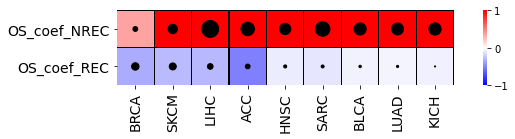

In [61]:
boPlot_gsea(corr=cox_ec_selected_final.loc[cox_order, ['OS_coef_NREC', 'OS_coef_REC']].astype(float).T,
            fdr=-np.log10(cox_ec_selected_final.loc[cox_order, ['OS_p_NREC', 'OS_p_REC']].astype(float)).T,
            path=panel_home + 'survival/z_scored_ec_cox_heatmap.pdf', fdr_threshold=0, vmin=-1, vmax=1)

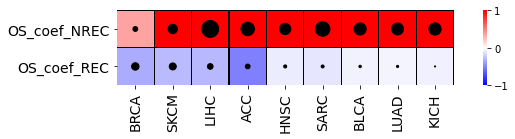

In [62]:
boPlot_gsea(corr=cox_ec_selected_final.loc[cox_order, ['OS_coef_NREC', 'OS_coef_REC']].astype(float).T,
            fdr=-np.log10(cox_ec_selected_final.loc[cox_order, ['OS_p_NREC', 'OS_p_REC']].astype(float)).T,
            path=panel_home + 'survival/z_scored_ec_cox_heatmap.png', fdr_threshold=0, vmin=-1, vmax=1)

## H-I. Immune infiltration

In [5]:
timer_estimation = pd.read_csv(panel_home + 'infiltration/timer_estimation.csv',
                               header=0, index_col=0, sep=',')

In [6]:
timer_estimation = timer_estimation.groupby(level=0).mean()

In [7]:
timer_estimation.shape

(9990, 6)

In [11]:
ave_ec_expr_uni = ave_ec_expr.groupby(level=0).first()

In [12]:
ave_ec_expr_uni.shape

(9968, 3)

In [13]:
ave_ec_expr

,ave_z_NREC,ave_z_REC,cancer_type
TCGA-33-6737-01A,0.118329,0.167876,LUSC
TCGA-25-2409-01A,-0.146220,0.330119,OV
TCGA-QR-A6GT-01A,0.338830,0.555007,PCPG
TCGA-CJ-4908-01A,0.033762,-0.077838,KIRC
TCGA-Q1-A73O-01A,0.069814,0.014695,CESC
...,...,...,...
TCGA-A2-A04Q-01A,0.035574,1.006797,BRCA
TCGA-IQ-A61H-01A,0.189679,-0.311658,HNSC
TCGA-B8-A54G-01A,-0.359418,0.905940,KIRC
TCGA-AP-A3K1-01A,0.054033,-0.373640,UCEC


In [24]:
# scatter plot
for ct in ['SKCM', 'LUAD', 'HNSC', 'BRCA']:
    tmp_ct_ec = ave_ec_expr_uni[ave_ec_expr_uni['cancer_type'] == ct]
    tmp_ct_timer = timer_estimation[timer_estimation.index.isin(tmp_ct_ec.index)]
    if tmp_ct_timer.shape[0] == 0:
        continue
    tmp_ct_ec = tmp_ct_ec[tmp_ct_ec.index.isin(tmp_ct_timer.index)]
   
    for im in tmp_ct_timer.columns:
        r_corr, r_p = stats.pearsonr(tmp_ct_ec['ave_z_NREC'], tmp_ct_timer[im])
        s_corr, s_p = stats.pearsonr(tmp_ct_ec['ave_z_REC'], tmp_ct_timer[im])

        plt.figure(figsize=(3, 3))
        sns.scatterplot(x=tmp_ct_ec['ave_z_NREC'], y=tmp_ct_timer[im], s=5, color='crimson')
        plt.xlabel('R signature')
        plt.title(ct + ' r = ' + str(np.round(r_corr, 2)) + ', p = ' + "{:.2e}".format(r_p))
        fig = plt.gcf()
        fig.savefig(panel_home + 'scatter_infiltration/' + ct + '_' + im + '_R.pdf', transparent=True)
        plt.close()
        
        plt.figure(figsize=(3, 3))
        sns.scatterplot(x=tmp_ct_ec['ave_z_REC'], y=tmp_ct_timer[im], s=5, color='royalblue')
        plt.xlabel('S signature')
        plt.title(ct + ' r = ' + str(np.round(s_corr, 2)) + ', p = ' + "{:.2e}".format(s_p))
        fig = plt.gcf()
        fig.savefig(panel_home + 'scatter_infiltration/' + ct + '_' + im + '_S.pdf', transparent=True)
        plt.close()
    

In [30]:
corr_NREC_time = df(index=ave_ec_expr_uni['cancer_type'].unique(), columns=timer_estimation.columns)
corr_REC_time = df(index=ave_ec_expr_uni['cancer_type'].unique(), columns=timer_estimation.columns)
p_NREC_time = df(index=ave_ec_expr_uni['cancer_type'].unique(), columns=timer_estimation.columns)
p_REC_time = df(index=ave_ec_expr_uni['cancer_type'].unique(), columns=timer_estimation.columns)


for ct in ave_ec_expr_uni['cancer_type'].unique():
    tmp_ct_ec = ave_ec_expr_uni[ave_ec_expr_uni['cancer_type'] == ct]
    tmp_ct_timer = timer_estimation[timer_estimation.index.isin(tmp_ct_ec.index)]
    if tmp_ct_timer.shape[0] == 0:
        continue
    tmp_ct_ec = tmp_ct_ec[tmp_ct_ec.index.isin(tmp_ct_timer.index)]
   
    for im in tmp_ct_timer.columns:
        corr_NREC_time.at[ct, im], p_NREC_time.at[ct, im] = stats.pearsonr(tmp_ct_ec['ave_z_NREC'], tmp_ct_timer[im])
        corr_REC_time.at[ct, im], p_REC_time.at[ct, im] = stats.pearsonr(tmp_ct_ec['ave_z_REC'], tmp_ct_timer[im])

In [31]:
corr_NREC_time.to_csv(panel_home + 'infiltration/corr_NREC_TIMER.csv', sep=',')
p_NREC_time.to_csv(panel_home + 'infiltration/p_NREC_TIMER.csv', sep=',')
corr_REC_time.to_csv(panel_home + 'infiltration/corr_REC_TIMER.csv', sep=',')
p_REC_time.to_csv(panel_home + 'infiltration/p_REC_TIMER.csv', sep=',')

In [32]:
# dropna for visualization
corr_NREC_time_dn = corr_NREC_time.dropna(axis=0, how='all').fillna(0)
p_NREC_time_dn = p_NREC_time[p_NREC_time.index.isin(corr_NREC_time_dn.index)].fillna(1)
corr_REC_time_dn = corr_REC_time.dropna(axis=0, how='all').fillna(0)
p_REC_time_dn = p_REC_time[p_REC_time.index.isin(corr_REC_time_dn.index)].fillna(1)

In [33]:
g = sns.clustermap(corr_NREC_time_dn, vmin=-.6, vmax=.6, cmap='bwr', method='ward')
plt.close()
reordered_x = [corr_NREC_time_dn.index[i] for i in g.dendrogram_row.reordered_ind]
reordered_y = [corr_NREC_time_dn.columns[i] for i in g.dendrogram_col.reordered_ind]

merge_corr_nrec_timer, merge_p_nrec_timer = df(corr_NREC_time.loc[reordered_x, reordered_y]), df(p_NREC_time.loc[reordered_x, reordered_y])

In [37]:
g = sns.clustermap(corr_REC_time_dn, vmin=-.6, vmax=.6, cmap='bwr', method='ward')
plt.close()
reordered_x = [corr_REC_time_dn.index[i] for i in g.dendrogram_row.reordered_ind]
reordered_y = [corr_REC_time_dn.columns[i] for i in g.dendrogram_col.reordered_ind]
merge_corr_rec_timer, merge_p_rec_timer = df(corr_REC_time.loc[reordered_x, reordered_y]), df(p_REC_time.loc[reordered_x, reordered_y])

In [34]:
def boPlot_infiltration(corr, fdr, fdr_threshold, vmin, vmax, size_adjuster, path=None):
    '''
    Visualize by bo plot for infiltration. Dot size indicate the significance, color indicate the correlation
    '''
    location = {}
    j = 1
    for ctype in fdr.columns:
        location[ctype] = df(index=fdr.index, columns=['x', 'y'])
        location[ctype]['fdr'] = fdr[ctype]
        location[ctype]['corr'] = corr[ctype]

        i = 1
        for t in location[ctype].index:
            location[ctype].at[t, 'y'] = i - .5
            location[ctype].at[t, 'x'] = j - .5
            i += 1
        j += 1

    # collapse all subframe to one
    mergeIndex = []
    for c in location.keys():
        mergeIndex.extend([c + '~' + x for x in location[c].index])
    mergeLoc = df(index=mergeIndex, columns=['x', 'y', 'fdr', 'corr'])
    for c in location.keys():
        for t in fdr.index:
            mergeLoc.at[c + '~' + t, 'x'] = location[c].loc[t, 'x']
            mergeLoc.at[c + '~' + t, 'y'] = location[c].loc[t, 'y']
            mergeLoc.at[c + '~' + t, 'fdr'] = location[c].loc[t, 'fdr']
            mergeLoc.at[c + '~' + t, 'corr'] = location[c].loc[t, 'corr']
    
    # remove points with p > 0.1
    mergeLoc = mergeLoc[mergeLoc['fdr'] >= fdr_threshold].dropna(axis=0, how='any')
    
    fig = plt.figure(figsize=(10, 3))
    ax = fig.add_subplot(111, aspect='equal')
    sns.heatmap(corr[corr > 1].fillna(0), vmin=vmin, vmax=vmax, cmap='bwr',
                square=True, linewidths=0.01, linecolor='k', xticklabels=True, yticklabels=True)

    # sns.scatterplot(x=mergeLoc['x'], y=mergeLoc['y'], size=mergeLoc['corr'], color='k', linewidths=False)
    ax.scatter(
        x=mergeLoc['x'], y=mergeLoc['y'],
        s=mergeLoc['fdr'].astype(float)*size_adjuster,
        edgecolor='k',
        # color='k',
        c=mergeLoc['corr'], cmap=plt.cm.bwr, vmin=vmin, vmax=vmax,
        )
    plt.xticks(rotation=90, fontsize=14)
    plt.yticks(rotation=0, fontsize=14)
    
    
    plt.subplots_adjust(left=0.1)
    plt.tight_layout()
    if path != None:
        fig = plt.gcf()
        fig.savefig(path, transparent=True)
    plt.show()

    return


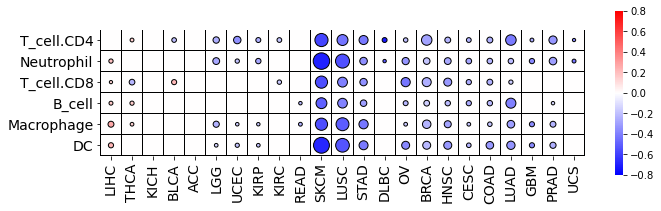

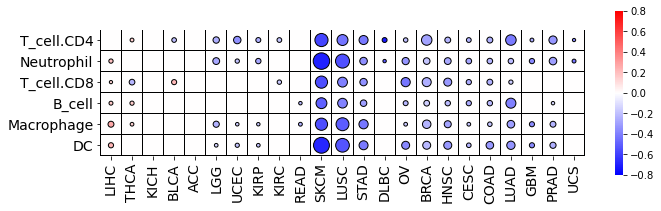

In [35]:
boPlot_infiltration(corr=merge_corr_nrec_timer.T.astype(float), fdr=-np.log10(merge_p_nrec_timer.T.astype(float)),
                    size_adjuster=5, fdr_threshold=2, vmin=-.8, vmax=.8,
                    path=panel_home + 'infiltration/z_scored_ec_NREC_TIMER.pdf')
boPlot_infiltration(corr=merge_corr_nrec_timer.T.astype(float), fdr=-np.log10(merge_p_nrec_timer.T.astype(float)),
                    size_adjuster=5, fdr_threshold=2, vmin=-.8, vmax=.8,
                    path=panel_home + 'infiltration/z_scored_ec_NREC_TIMER.png')

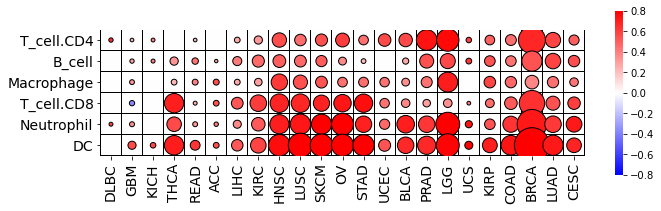

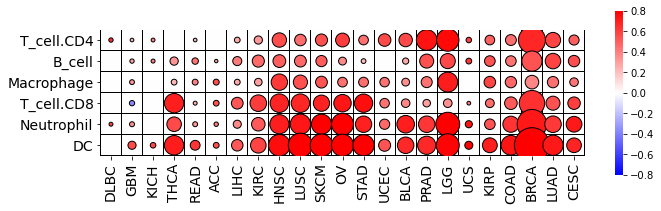

In [38]:
boPlot_infiltration(corr=merge_corr_rec_timer.T.astype(float), fdr=-np.log10(merge_p_rec_timer.T.astype(float)),
                    size_adjuster=5, fdr_threshold=2, vmin=-.8, vmax=.8,
                    path=panel_home + 'infiltration/z_scored_ec_REC_TIMER.pdf')
boPlot_infiltration(corr=merge_corr_rec_timer.T.astype(float), fdr=-np.log10(merge_p_rec_timer.T.astype(float)),
                    size_adjuster=5, fdr_threshold=2, vmin=-.8, vmax=.8,
                    path=panel_home + 'infiltration/z_scored_ec_REC_TIMER.png')

## J-K independent validation

In [5]:
mean_168204 = pd.read_csv(data_home + '/GSE168204/log2mean_168204.csv',
                          index_col=0, header=0, sep=',')

In [6]:
mean_168204

,NR_PRE,NR_POST,R_PRE,R_POST
Gene,,,,
A2M,13.027285,13.476525,13.725186,13.875666
A4GALT,7.361300,7.810007,8.533980,6.640893
AAAS,8.494124,8.254366,8.103138,7.189602
AACS,9.015874,9.706034,8.011986,8.244765
AADAC,0.400000,3.743114,3.317180,5.068936
...,...,...,...,...
ZWINT,4.425786,4.371945,2.068859,1.098079
ZXDC,8.990679,8.746638,9.394959,9.720917
ZYX,11.927111,10.471165,11.416826,11.876576


In [404]:
z_mean_168204 = ((mean_168204.T - mean_168204.T.mean(axis=0)) / mean_168204.T.std(axis=0)).T

In [405]:
z_mean_168204

,NR_PRE,NR_POST,R_PRE,R_POST
Gene,,,,
A2M,-1.344394,-0.133772,0.536325,0.941841
A4GALT,-0.283590,0.281345,1.192848,-1.190603
AAAS,0.848315,0.427928,0.162767,-1.439009
AACS,0.351646,1.246500,-0.949983,-0.648164
AADAC,-1.388115,0.310313,0.093922,0.983880
...,...,...,...,...
ZWINT,0.857394,0.825216,-0.551214,-1.131396
ZXDC,-0.516181,-1.082035,0.421213,1.177003
ZYX,0.747221,-1.410516,-0.009031,0.672327


In [394]:
mean_ec_168204 = mean_168204[mean_168204.index.isin(gene_sets['NREC_profile'] + gene_sets['REC_profile'])]

In [407]:
z_mean_ec_168204 = z_mean_168204[z_mean_168204.index.isin(gene_sets['NREC_profile'] + gene_sets['REC_profile'])]

In [419]:
z_mean_ec_168204.loc[z_mean_ec_168204[z_mean_ec_168204.index.isin(gene_sets['NREC_profile'])].index, 'EC'] = 'NREC'
z_mean_ec_168204.loc[z_mean_ec_168204[z_mean_ec_168204.index.isin(gene_sets['REC_profile'])].index, 'EC'] = 'REC'

/home/dyang-server/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/dyang-server/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [409]:
mean_ec_168204.loc[mean_ec_168204[mean_ec_168204.index.isin(gene_sets['NREC_profile'])].index, 'EC'] = 'NREC'
mean_ec_168204.loc[mean_ec_168204[mean_ec_168204.index.isin(gene_sets['REC_profile'])].index, 'EC'] = 'REC'

/home/dyang-server/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/dyang-server/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [411]:
mean_ec_168204

,NR_PRE,NR_POST,R_PRE,R_POST,EC
Gene,,,,,
AAAS,8.494124,8.254366,8.103138,7.189602,NREC
AACS,9.015874,9.706034,8.011986,8.244765,NREC
AAR2,10.766913,10.899863,10.017226,9.447780,NREC
ABCA1,9.787883,10.050723,11.623797,12.249547,REC
ABCB6,10.782721,10.588744,10.228624,9.802754,NREC
...,...,...,...,...,...
ZNF609,10.588275,10.861487,11.087780,11.469864,NREC
ZNF623,9.611875,9.550252,9.631755,9.905024,NREC
ZNF74,10.090445,9.823600,8.440473,8.556608,NREC


<AxesSubplot:>

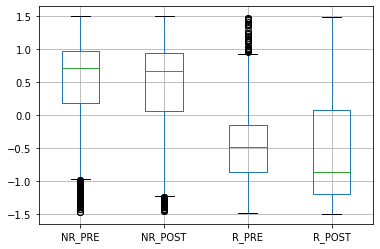

In [420]:
z_mean_ec_168204[z_mean_ec_168204['EC'] == 'NREC'].boxplot()

<AxesSubplot:>

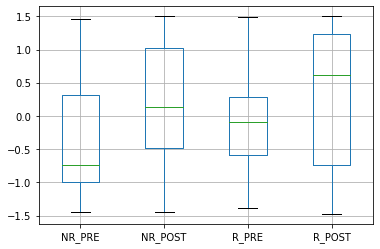

In [421]:
z_mean_ec_168204[z_mean_ec_168204['EC'] == 'REC'].boxplot()

In [422]:
z_mean_ec_168204['NR_TEC'] = z_mean_ec_168204['NR_POST'] - z_mean_ec_168204['NR_PRE']
z_mean_ec_168204['R_TEC'] = z_mean_ec_168204['R_POST'] - z_mean_ec_168204['R_PRE']

<ipython-input-422-ad2aed0a2b23>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z_mean_ec_168204['NR_TEC'] = z_mean_ec_168204['NR_POST'] - z_mean_ec_168204['NR_PRE']
<ipython-input-422-ad2aed0a2b23>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z_mean_ec_168204['R_TEC'] = z_mean_ec_168204['R_POST'] - z_mean_ec_168204['R_PRE']


In [414]:
mean_ec_168204['NR_TEC'] = mean_ec_168204['NR_POST'] - mean_ec_168204['NR_PRE']
mean_ec_168204['R_TEC'] = mean_ec_168204['R_POST'] - mean_ec_168204['R_PRE']

<ipython-input-414-d8c19d7f90e5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_ec_168204['NR_TEC'] = mean_ec_168204['NR_POST'] - mean_ec_168204['NR_PRE']
<ipython-input-414-d8c19d7f90e5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_ec_168204['R_TEC'] = mean_ec_168204['R_POST'] - mean_ec_168204['R_PRE']


In [488]:
mean_ec_168204

,NR_PRE,NR_POST,R_PRE,R_POST,EC,NR_TEC,R_TEC
Gene,,,,,,,
AAAS,8.494124,8.254366,8.103138,7.189602,NREC,-0.239758,-0.913536
AACS,9.015874,9.706034,8.011986,8.244765,NREC,0.690160,0.232779
AAR2,10.766913,10.899863,10.017226,9.447780,NREC,0.132950,-0.569446
ABCA1,9.787883,10.050723,11.623797,12.249547,REC,0.262840,0.625750
ABCB6,10.782721,10.588744,10.228624,9.802754,NREC,-0.193976,-0.425869
...,...,...,...,...,...,...,...
ZNF609,10.588275,10.861487,11.087780,11.469864,NREC,0.273212,0.382084
ZNF623,9.611875,9.550252,9.631755,9.905024,NREC,-0.061623,0.273269
ZNF74,10.090445,9.823600,8.440473,8.556608,NREC,-0.266846,0.116135


In [489]:
mean_ec_168204['comparison'] = mean_ec_168204['NR_TEC'] - mean_ec_168204['R_TEC']

<ipython-input-489-15102ec0a4dd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_ec_168204['comparison'] = mean_ec_168204['NR_TEC'] - mean_ec_168204['R_TEC']


<AxesSubplot:xlabel='comparison', ylabel='EC'>

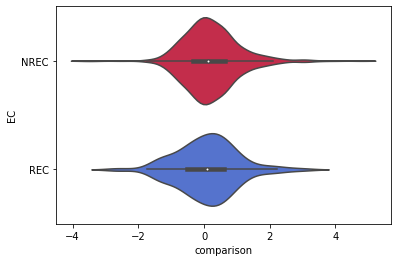

In [491]:
sns.violinplot(x='comparison', y='EC', data=mean_ec_168204, palette={'NREC': 'crimson', 'REC': 'royalblue'})

In [375]:
for g in mean_ec_168204.index:
    if mean_ec_168204.loc[g, 'comparison'] <= -3:
        mean_ec_168204.at[g, 'comparison_cat'] = '<= -3'
    elif mean_ec_168204.loc[g, 'comparison'] > -3 and mean_ec_168204.loc[g, 'comparison'] <= -1.5:
        mean_ec_168204.at[g, 'comparison_cat'] = '<= -1.5'
    elif mean_ec_168204.loc[g, 'comparison'] > -1.5 and mean_ec_168204.loc[g, 'comparison'] <= 0:
        mean_ec_168204.at[g, 'comparison_cat'] = '<= 0'
    elif mean_ec_168204.loc[g, 'comparison'] > 0 and mean_ec_168204.loc[g, 'comparison'] <= 1.5:
        mean_ec_168204.at[g, 'comparison_cat'] = '> 0'
    elif mean_ec_168204.loc[g, 'comparison'] > 1.5 and mean_ec_168204.loc[g, 'comparison'] <= 3:
        mean_ec_168204.at[g, 'comparison_cat'] = '> 1.5'
    elif mean_ec_168204.loc[g, 'comparison'] > 3:
        mean_ec_168204.at[g, 'comparison_cat'] = '> 3'

In [378]:
ec_count = df(pd.crosstab(mean_ec_168204['EC'], mean_ec_168204['comparison_cat']))

In [388]:
ec_count.sum(axis=1)

EC
NREC    1184
REC      138
dtype: int64

In [391]:
ec_percent = ec_count.copy().T
ec_percent['NREC'] = ec_percent['NREC'] / 1184
ec_percent['REC'] = ec_percent['REC'] / 138

In [392]:
ec_percent

EC,NREC,REC
comparison_cat,,
<= -1.5,0.006757,0.021739
<= -3,0.002534,0.000000
<= 0,0.416385,0.427536
> 0,0.503378,0.492754
> 1.5,0.061655,0.050725
> 3,0.009291,0.007246


In [426]:
mean_ec_168204

,NR_PRE,NR_POST,R_PRE,R_POST,EC,NR_TEC,R_TEC
Gene,,,,,,,
AAAS,8.494124,8.254366,8.103138,7.189602,NREC,-0.239758,-0.913536
AACS,9.015874,9.706034,8.011986,8.244765,NREC,0.690160,0.232779
AAR2,10.766913,10.899863,10.017226,9.447780,NREC,0.132950,-0.569446
ABCA1,9.787883,10.050723,11.623797,12.249547,REC,0.262840,0.625750
ABCB6,10.782721,10.588744,10.228624,9.802754,NREC,-0.193976,-0.425869
...,...,...,...,...,...,...,...
ZNF609,10.588275,10.861487,11.087780,11.469864,NREC,0.273212,0.382084
ZNF623,9.611875,9.550252,9.631755,9.905024,NREC,-0.061623,0.273269
ZNF74,10.090445,9.823600,8.440473,8.556608,NREC,-0.266846,0.116135


<AxesSubplot:xlabel='variable', ylabel='value'>

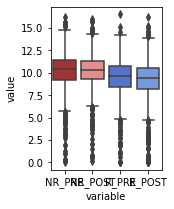

In [452]:
plt.figure(figsize=(2, 3))
sns.boxplot(x='variable', y='value',
            data=pd.melt(mean_ec_168204[mean_ec_168204['EC'] == 'NREC'][['NR_PRE', 'NR_POST', 'R_PRE', 'R_POST']]),
            palette={'NR_PRE': 'firebrick', 'NR_POST': 'lightcoral',
                     'R_PRE': 'royalblue', 'R_POST': 'cornflowerblue'})

<AxesSubplot:xlabel='variable', ylabel='value'>

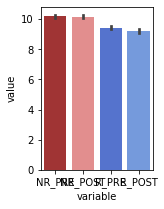

In [461]:
plt.figure(figsize=(2, 3))
sns.barplot(x='variable', y='value',
            data=pd.melt(mean_ec_168204[mean_ec_168204['EC'] == 'NREC'][['NR_PRE', 'NR_POST', 'R_PRE', 'R_POST']]),
            palette={'NR_PRE': 'firebrick', 'NR_POST': 'lightcoral',
                     'R_PRE': 'royalblue', 'R_POST': 'cornflowerblue'})

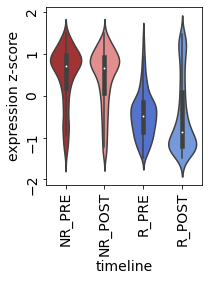

In [484]:
plt.figure(figsize=(3, 4))
sns.violinplot(x='variable', y='value',
            data=pd.melt(z_mean_ec_168204[z_mean_ec_168204['EC'] == 'NREC'][['NR_PRE', 'NR_POST', 'R_PRE', 'R_POST']]),
            palette={'NR_PRE': 'firebrick', 'NR_POST': 'lightcoral',
                     'R_PRE': 'royalblue', 'R_POST': 'cornflowerblue'})
plt.xticks(rotation=90, fontsize=14)
plt.xlabel('timeline', fontsize=14)
plt.yticks(rotation=90, fontsize=14)
plt.ylabel('expression z-score', fontsize=14)
plt.tight_layout()
fig = plt.gcf()
fig.savefig(panel_home + '/validation/GSE168204_NREC.png', transparent=True, dpi=300)
fig.savefig(panel_home + '/validation/GSE168204_NREC.pdf', transparent=True)

<AxesSubplot:xlabel='variable', ylabel='value'>

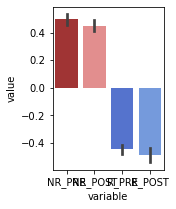

In [460]:
plt.figure(figsize=(2, 3))
sns.barplot(x='variable', y='value',
            data=pd.melt(z_mean_ec_168204[z_mean_ec_168204['EC'] == 'NREC'][['NR_PRE', 'NR_POST', 'R_PRE', 'R_POST']]),
            palette={'NR_PRE': 'firebrick', 'NR_POST': 'lightcoral',
                     'R_PRE': 'royalblue', 'R_POST': 'cornflowerblue'})

<AxesSubplot:xlabel='variable', ylabel='value'>

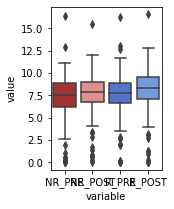

In [454]:
plt.figure(figsize=(2, 3))
sns.boxplot(x='variable', y='value',
            data=pd.melt(mean_ec_168204[mean_ec_168204['EC'] == 'REC'][['NR_PRE', 'NR_POST', 'R_PRE', 'R_POST']]),
            palette={'NR_PRE': 'firebrick', 'NR_POST': 'lightcoral',
                     'R_PRE': 'royalblue', 'R_POST': 'cornflowerblue'})

<AxesSubplot:xlabel='variable', ylabel='value'>

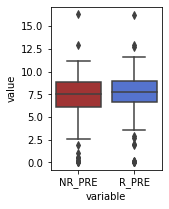

In [467]:
plt.figure(figsize=(2, 3))
sns.boxplot(x='variable', y='value',
            data=pd.melt(mean_ec_168204[mean_ec_168204['EC'] == 'REC'][['NR_PRE', 'R_PRE']]),
            palette={'NR_PRE': 'firebrick', 'NR_POST': 'lightcoral',
                     'R_PRE': 'royalblue', 'R_POST': 'cornflowerblue'})

<AxesSubplot:xlabel='variable', ylabel='value'>

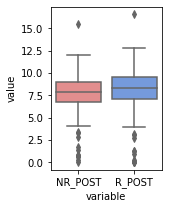

In [466]:
plt.figure(figsize=(2, 3))
sns.boxplot(x='variable', y='value',
            data=pd.melt(mean_ec_168204[mean_ec_168204['EC'] == 'REC'][['NR_POST', 'R_POST']]),
            palette={'NR_PRE': 'firebrick', 'NR_POST': 'lightcoral',
                     'R_PRE': 'royalblue', 'R_POST': 'cornflowerblue'})

<AxesSubplot:xlabel='variable', ylabel='value'>

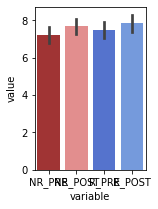

In [459]:
plt.figure(figsize=(2, 3))
sns.barplot(x='variable', y='value',
            data=pd.melt(mean_ec_168204[mean_ec_168204['EC'] == 'REC'][['NR_PRE', 'NR_POST', 'R_PRE', 'R_POST']]),
            palette={'NR_PRE': 'firebrick', 'NR_POST': 'lightcoral',
                     'R_PRE': 'royalblue', 'R_POST': 'cornflowerblue'})

<AxesSubplot:xlabel='variable', ylabel='value'>

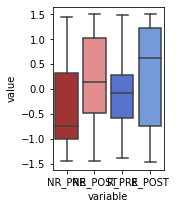

In [456]:
plt.figure(figsize=(2, 3))
sns.boxplot(x='variable', y='value',
            data=pd.melt(z_mean_ec_168204[z_mean_ec_168204['EC'] == 'REC'][['NR_PRE', 'NR_POST', 'R_PRE', 'R_POST']]),
            palette={'NR_PRE': 'firebrick', 'NR_POST': 'lightcoral',
                     'R_PRE': 'royalblue', 'R_POST': 'cornflowerblue'})

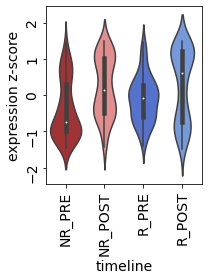

In [485]:
plt.figure(figsize=(3, 4))
sns.violinplot(x='variable', y='value',
            data=pd.melt(z_mean_ec_168204[z_mean_ec_168204['EC'] == 'REC'][['NR_PRE', 'NR_POST', 'R_PRE', 'R_POST']]),
            palette={'NR_PRE': 'firebrick', 'NR_POST': 'lightcoral',
                     'R_PRE': 'royalblue', 'R_POST': 'cornflowerblue'})
plt.xticks(rotation=90, fontsize=14)
plt.xlabel('timeline', fontsize=14)
plt.yticks(rotation=90, fontsize=14)
plt.ylabel('expression z-score', fontsize=14)
plt.tight_layout()
fig = plt.gcf()
fig.savefig(panel_home + '/validation/GSE168204_REC.png', transparent=True, dpi=300)
fig.savefig(panel_home + '/validation/GSE168204_REC.pdf', transparent=True)

<AxesSubplot:xlabel='variable', ylabel='value'>

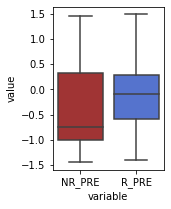

In [468]:
plt.figure(figsize=(2, 3))
sns.boxplot(x='variable', y='value',
            data=pd.melt(z_mean_ec_168204[z_mean_ec_168204['EC'] == 'REC'][['NR_PRE', 'R_PRE']]),
            palette={'NR_PRE': 'firebrick', 'NR_POST': 'lightcoral',
                     'R_PRE': 'royalblue', 'R_POST': 'cornflowerblue'})

<AxesSubplot:xlabel='variable', ylabel='value'>

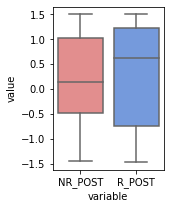

In [469]:
plt.figure(figsize=(2, 3))
sns.boxplot(x='variable', y='value',
            data=pd.melt(z_mean_ec_168204[z_mean_ec_168204['EC'] == 'REC'][['NR_POST', 'R_POST']]),
            palette={'NR_PRE': 'firebrick', 'NR_POST': 'lightcoral',
                     'R_PRE': 'royalblue', 'R_POST': 'cornflowerblue'})

<AxesSubplot:xlabel='variable', ylabel='value'>

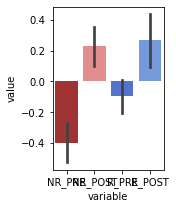

In [458]:
plt.figure(figsize=(2, 3))
sns.barplot(x='variable', y='value',
            data=pd.melt(z_mean_ec_168204[z_mean_ec_168204['EC'] == 'REC'][['NR_PRE', 'NR_POST', 'R_PRE', 'R_POST']]),
            palette={'NR_PRE': 'firebrick', 'NR_POST': 'lightcoral',
                     'R_PRE': 'royalblue', 'R_POST': 'cornflowerblue'})